# Evaluation of coolant pumping powers 
### For gas cooling circuits

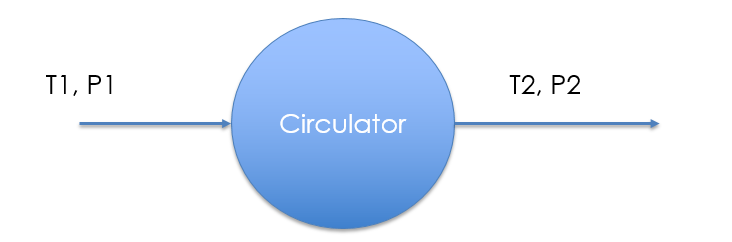


First I will show how to calculate the work across a pump if the inlet temperature is known making use of the ideal gas relationships for an isentropic process. 
$$
 (\frac{T_2}{T_1}) = (\frac{P_2}{P_1})^{(k-1)/k} = (\frac{v_1}{v_2})^k
 $$
It is important to realize that all calculations are performed in specific mass notation, meaning they are normalized with respect to the mass flow rate. h = enthalpy in the below calcs and for gasses with constant specific heats,

$$
h_2-h_1 = c_p \cdot (T_2-T_1) \\
Ẇ = ṁ \Delta h =ṁ \cdot c_p \cdot (T_2 - T_1) \\
ẇ =Ẇ / ṁ= c_p \cdot (T_2 - T_1)
$$



The below code uses the Symbolics package to show the derivation of the compressor work

In [6]:
using Symbolics, SymbolicUtils
@variables c_p k η_circulator rp T_1 ẇ_actual T_2 ṁ Ẇ
# cp_helium     = specific heat of helium 
# k             = Ratio of specific heats, cp/cv = 1.666 for Helium
# η_circulator  = Isentropic effeciency of circulator = (Isentropic work required)  / (Actual work required) 
# rp            = compression ration , P2/P1
# T1            = inlet temperature of fluid

# Evalute the ideal (isentropic) case
T2_isentropic                   = T_1 * rp^((k-1)/k)                 #isentropic outlet temperature
isentropic_specific_work        = c_p*(T2_isentropic - T_1)           #isentropic specific work in (J/kg)

# use the isentropic effeciency to find the actual specific work
actual_specific_work = isentropic_specific_work / η_circulator
T2_actual = actual_specific_work/c_p+T_1

eq2 = T_2 == T2_actual
eq1 = ẇ_actual== actual_specific_work
eq3 = Ẇ == ẇ_actual * ṁ

display("The specific work, outlet temperature, and total work of a gas compressor")
display(eq1)
display(eq2)
display(eq3)

"The specific work, outlet temperature, and total work of a gas compressor"

ẇ_actual == ((c_p*(T_1*(rp^((k - 1) / k)) - T_1)) / η_circulator)

T_2 == (T_1 + (T_1*(rp^((k - 1) / k)) - T_1) / η_circulator)

Ẇ == (ṁ*ẇ_actual)

However, in the FUSE cases, T1 is typically unknown as we would rather specify the fluid temperature at the inlet to the system (blanket/divertor) as opposed to before the pump. In this case, the second equation above can be re-arranged as:
$$
T_1 = \frac{T_2}{(1 + \frac{rp^{(k-1)/k}-1}{\eta_{circ}})}

$$

# Evalution in FUSE
### Deriving the formulas used in the balance of plant and thermal cycle actor
The below code uses the Symbolics.jl toolbox to evaluate the expressions

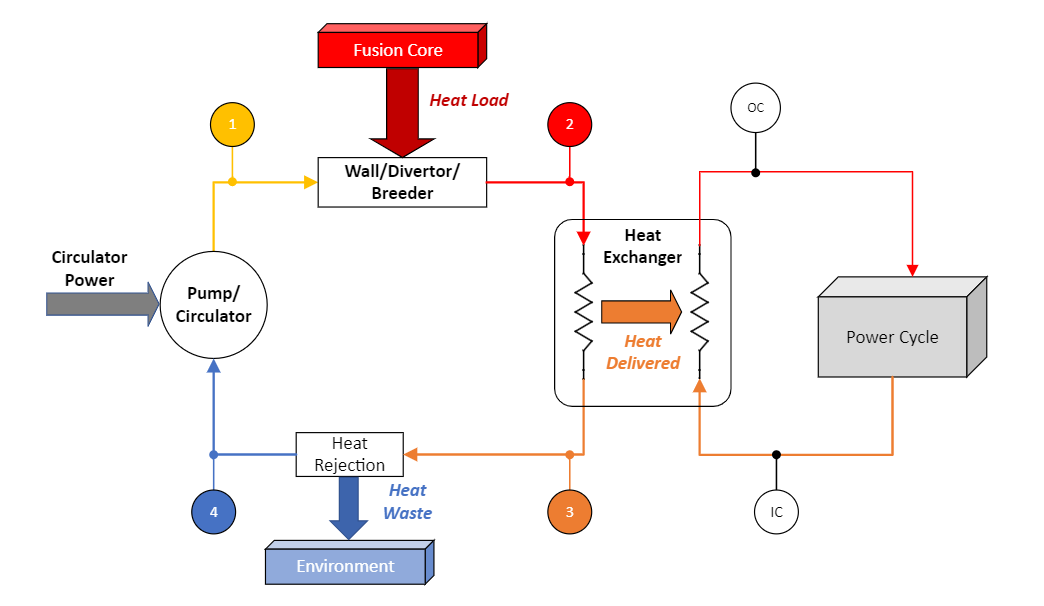

Notes:
Ideally, T3 = T4 however this is not always the case. For example, if the temperature at the cycle point IC > T2, then no heat can be delivered and all fusion heat must be rejected

### Preliminaries
#### Constants and properties of the system
cp_helium   = specific heat of helium <.br>
k           = Ratio of specific heats, cp/cv = 1.666 for Helium

η_circulator = Isentropic effeciency of circulator

#### Specified variables
Pin_circulator    = Nominal pressure of fluid circuit at point 1

T1 and T2         = are the desired inlet and outlet temperatures through the cooling route 
#### System Parameters
ΔP_circulator = pressure drop assumed across entire cooling route, which is the amount of pressure the circulator must supply to the system

Q_heat_load = heat load on system


In [7]:
# Constants and properties of the system
@variables cp_helium k η_circulator
# cp_helium = specific heat of helium 
# k = Ratio of specific heats, cp/cv = 1.666 for Helium
# η_circulator = Isentropic effeciency of circulator

# Specified variables
@variables Pin_circulator T_1 T_2
# Pin_circulator    = Nominal pressure of fluid circuit at point 1
# T1 and T2         = are the desired inlet and outlet temperatures through the cooling route 
#                       i.e. at the inlet and outlet of the divertor system, 

# System Parameters
@variables ΔP_circulator Q_heat_load
# ΔP_circulator = pressure drop assumed across entire cooling route, which is the amount of pressure the circulator must supply to the system
# Q_heat_load = heat load on system

2-element Vector{Num}:
 ΔP_circulator
           Q_heat_load

Calculating flow rate from the heat load and desired temperature profile

In [8]:
# CALCULATION
@variables ṁ
mflow = ṁ ==   Q_heat_load/(cp_helium * (T_2 - T_1))         # required mass flow to maintain temperatures T1 and T2
mf = Q_heat_load/(cp_helium * (T_2 - T_1))                  # saving non-symbolic variable for use later
display(mflow)

ṁ == (Q_heat_load / (cp_helium*(T_2 - T_1)))

Calculating T4 from known values

In [9]:
# Calculating circulator work
Pout_circulator     = Pin_circulator + ΔP_circulator        # outlet pressure
compression_ratio   = Pout_circulator / Pin_circulator      # compression ratio

# Isentropic system evaluation
T4 = T_1/(1+(compression_ratio^((k-1)/k)-1)/η_circulator)
@variables T_4
eq = T_4 == T4
display(eq)


T_4 == (T_1 / (1 + (((Pin_circulator + ΔP_circulator) / Pin_circulator)^((k - 1) / k) - 1) / η_circulator))

Now calculating the input work required

In [10]:
@variables ẇ Ẇ
eq1 = ẇ == cp_helium*(T_1-T4)
specific_work = cp_helium*(T_1-T4)
eq2 = Ẇ == mf*specific_work

display(eq1)
display(eq2)


ẇ == (cp_helium*(T_1 + (-T_1) / (1 + (((Pin_circulator + ΔP_circulator) / Pin_circulator)^((k - 1) / k) - 1) / η_circulator)))

Ẇ == ((Q_heat_load*(T_1 + (-T_1) / (1 + (((Pin_circulator + ΔP_circulator) / Pin_circulator)^((k - 1) / k) - 1) / η_circulator))) / (T_2 - T_1))